# 🌊 BinWaves Cantabria (Propagation)

### BinWaves Notebooks Overview

This Jupyter Notebook is the first of three in the **BinWaves** modeling workflow, following Cagigal et al., 2024 :

1. `BinWaves_Propagation.ipynb`  
2. `BinWaves_Reconstruction.ipynb`  
3. `BinWaves_Validation.ipynb`

---

#### Before You Start

Make sure you have:

- Installed the latest version of `bluemath-tk`:  
  ```bash
  pip install bluemath-tk

Before continuing, ensure you have **created and activated a Python environment**.

*** Other Required Packages ***
- `wavespectra` 
- `cartopy`
 
---

<details open>
<summary><strong>📁 BinWaves_Propagation.ipynb</strong></summary>

This notebook constructs the **library of pre-run cases** for all **monochromatic wave systems**.

##### Requirements:

- A **bathymetry** file placed in the `common_inputs/` folder, in the correct format.

If you don't have a specific bathymetry file for your study area, you can:

- **Download GEBCO bathymetry data** (~400 m resolution):  [https://download.gebco.net/](https://download.gebco.net/)
- **NOTE**: You can use the `Bathymetry_GEBCO.ipynb` notebook to convert it to the required format.

</details>

---

<details>
<summary><strong>📁 BinWaves_Reconstruction.ipynb</strong></summary>

This notebook reconstructs **wave conditions** using **offshore directional wave spectra**.

##### Requirements:

- Offshore wave spectrum data (e.g., **CAWCR** or **ERA5** datasets).
  - CAWCR spectra can be downloaded using a helper script (e.g., Javi's code?).

- **NOTE**: Optionally, apply **satellite corrections** to the hindcast spectrum before running BinWaves using the `CalVal` notebook, which handles the required format conversions.

</details>

---

<details>
<summary><strong>📁 BinWaves_Validation.ipynb</strong></summary>

This notebook performs **validation** using **wave buoy data**, if available.

##### Requirements:

- Wave buoy data in a format compatible with BinWaves (if available).
- Data can be freely downloaded from:  
  🌊 [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/)

- **NOTE:** You can use the `NDBC_buoy_data.ipynb` notebook to:
  - Download the buoy data.
  - Convert it into the appropriate format for BinWaves.

</details>

### 📌 In This Notebook: `BinWaves_Propagation.ipynb`

This notebook handles the **construction of the wave propagation library** by simulating wave cases.

### Steps:

- Generate wave conditions for all specified frequencies** and directions**.
- Set up and run SWAN simulations.
- Extract and save outputs from each simulation.
- Visualize the full wave library, including larger illustrative examples.



> ⚠️ **Coordinate System Note**  
> The BinWaves (SWAN) model can run in either **Spherical** or **Cartesian** coordinates:
> - Use **spherical coordinates** for areas larger than **100 km**.
> - Make sure your bathymetry file matches the coordinate system used in your simulation.

<!-- ### Before running the BinWaves notebooks, make sure you have:
- The lated version of the bluemath_tk installed pip install bluemath-tk and you have created a python environment 

#### BinWaves_Propagation.ipynb
- The bathymetry file in the common_inputs folder, in the correct format. If you don't have specific bathymetry for your study area, you can download it from https://download.gebco.net/ (asround 400m resolution) and the code Bathymetry_GEBCO.ipynb can be used to generate a bathymetry file with the right format to run the BinWaves model. 

NOTE: The BinWaves (SWAN MODEL) can be run in spheric or cartesian coordinates. If you want to run it in spherical coordinates, you need to have the bathymetry file in spherical coordinates. If you want to run it in cartesian coordinates, you need to have the bathymetry file in cartesian coordinates. For areas >100Km speheric coordinates are recommended.are recommended.

#### BinWaves_Reconstruction.ipynb
- Offshore wave spectrum data. They can be obtained from sources as CAWCR or ERA_5. In this case, CAWCR hindcast wave spectrum was used. 
 CAWCAR wave spectrum can be downloaded using (Javi code??). 
- You can used the download spectrum or you can make a satellite correction before running teh BinWaves usingt the code CalVal. This code handle the necesary converstions to leave te spectrum in teh desired format from teh BinWaves.

#### BinWaves_Validation.ipynb
 Wave Buoy information if possible. Make sure the wave buoy data is saveed in the compatible format for the BinWaves Code. You can download freely wave buoy information from 🔗 [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/) and the jupyter notebook NDBC_buoy_data.ipynb allows you download waybuoy information and converted in the appropiate formmat for running the BinWaves related code. -->

## Generate computational bathymetry

In [1]:
import xarray as xr
from utils.plotting import detect_coordinate_system

# Load the data
ds = xr.open_dataset("inputs/QGIS_bathy_june_2025_utm17N_100m_renamed.nc")

# Detect coordinate system to use the correct plotting function
coords = detect_coordinate_system(ds)
is_geographic = coords["is_geographic"]
x_coord = coords["x_coord"]
y_coord = coords["y_coord"]

# NOTE: The bathymetry should have positive values for sea and negative values for land
bathy = -(
    ds.transpose(y_coord, x_coord)
    .isel(
        x=slice(None, None, 30), y=slice(None, None, 30)
    )  # if you want to crop the bathymetry
    .sortby(y_coord, ascending=False)
    .elevation
)
bathy

<xarray.DataArray 'elevation' (y: 97, x: 95)> Size: 37kB
array([[  nan,   nan,   nan, ..., -471., -326., -215.],
       [ -49.,  -43.,  -46., ..., -374., -476., -145.],
       [ -69., -101., -147., ..., -329., -429., -347.],
       ...,
       [  nan, 3399., 3426., ..., 3545., 3538., 3493.],
       [  nan, 3368., 3414., ..., 3582., 3602., 3616.],
       [  nan, 3325., 3351., ...,   nan,   nan,   nan]],
      shape=(97, 95), dtype=float32)
Coordinates:
  * x        (x) float64 760B 5.527e+05 5.557e+05 ... 8.317e+05 8.347e+05
  * y        (y) float64 776B 1.007e+06 1.004e+06 ... 7.216e+05 7.186e+05
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  transverse_mercator

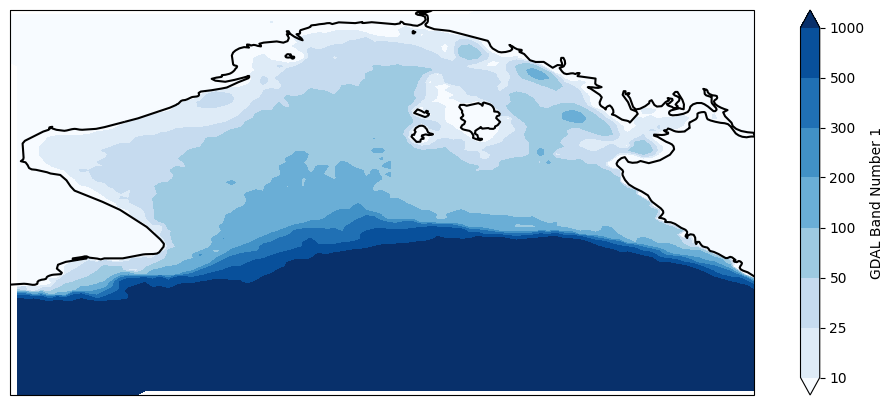

In [2]:
from utils.plotting import plot_selected_bathy

# if not buoys available  just run plot_selected_bathy(bathy=bathy)
buoys = None

plot_selected_bathy(bathy=bathy, buoys=buoys, utm_zone=17)

## SWAN Grid Parameters

This section defines the computational grid for running the SWAN model:

- **`xpc`, `ypc`**: Origin coordinates of the grid (in meters for Cartesian, degrees for spherical).  
  - Default = `0.0` for Cartesian; required for spherical.

- **`alpc`**: Angle of the positive x-axis (degrees, Cartesian convention).  
  - Default = `0.0`.

- **`xlenc`, `ylenc`**: Grid length in the x- and y-directions.  
  - Units: meters (Cartesian), degrees (spherical).  

- **`mxc`, `myc`**: Number of grid cells in x- and y-directions (1 less than number of grid points).  
  - In 1D mode, `myc` = `0`.

<center>
    <img src="assets/SWAN_grid.png" width="80%">
</center>





> ⚠️ **Grid Rotation**  
> 
> - **`rotation = True`**: A larger bathymetry domain than the computational grid is required to accommodate rotation.  
> - **`rotation = False`**: You can choose whether the grid covers the full bathymetry domain or just a subset.  
> 
> If the grid is **not rotated** and you want to use the **entire bathymetry**, grid parameters are computed automatically.  
> Otherwise, you must manually provide the desired coordinates.




In [3]:
from bluemath_tk.topo_bathy.swan_grid import generate_grid_parameters

fixed_parameters = generate_grid_parameters(bathy_data=bathy)
fixed_parameters

Please enter the following parameters:


{'xpc': 552703.1623,
 'ypc': 718570.3849,
 'alpc': 0.0,
 'xlenc': 282000.0,
 'ylenc': 288000.0,
 'mxc': 94,
 'myc': 96,
 'xpinp': 552703.1623,
 'ypinp': 718570.3849,
 'alpinp': 0.0,
 'mxinp': 94,
 'myinp': 96,
 'dxinp': 3000.0,
 'dyinp': 3000.0}

In [4]:
from utils.operations import locations_grid_outputs

locations = locations_grid_outputs(
    fixed_parameters,
    is_geographic=False,
    out_dx=90000,
    out_dy=90000,
    buoy_locations=buoys,
)
locations

array([[ 552703.1623,  718570.3849],
       [ 623203.1623,  718570.3849],
       [ 693703.1623,  718570.3849],
       [ 764203.1623,  718570.3849],
       [ 834703.1623,  718570.3849],
       [ 552703.1623,  790570.3849],
       [ 623203.1623,  790570.3849],
       [ 693703.1623,  790570.3849],
       [ 764203.1623,  790570.3849],
       [ 834703.1623,  790570.3849],
       [ 552703.1623,  862570.3849],
       [ 623203.1623,  862570.3849],
       [ 693703.1623,  862570.3849],
       [ 764203.1623,  862570.3849],
       [ 834703.1623,  862570.3849],
       [ 552703.1623,  934570.3849],
       [ 623203.1623,  934570.3849],
       [ 693703.1623,  934570.3849],
       [ 764203.1623,  934570.3849],
       [ 834703.1623,  934570.3849],
       [ 552703.1623, 1006570.3849],
       [ 623203.1623, 1006570.3849],
       [ 693703.1623, 1006570.3849],
       [ 764203.1623, 1006570.3849],
       [ 834703.1623, 1006570.3849]])

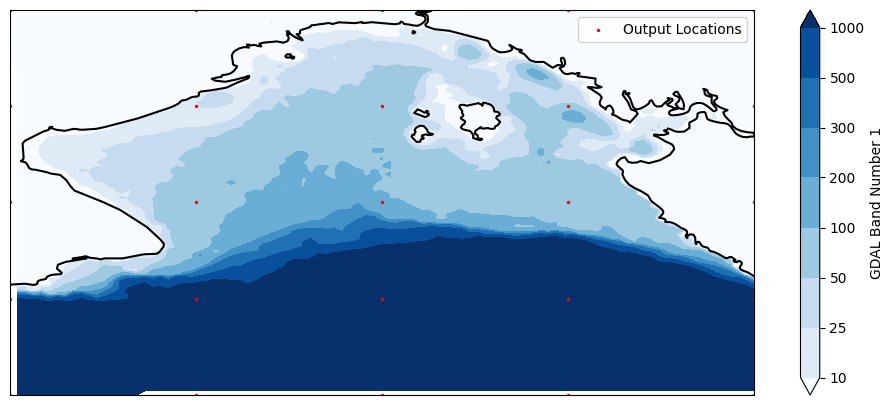

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.plotting import plot_selected_bathy

# Get the projection from your bathy or set it manually
coords = detect_coordinate_system(bathy)
proj = coords["proj"]  # This is a Cartopy projection object

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={"projection": ccrs.UTM(zone=17)})
plot_selected_bathy(bathy=bathy, utm_zone=17, buoys=buoys, ax=ax)
ax.scatter(
    locations[:, 0],
    locations[:, 1],
    color="red",
    s=2,
    label="Output Locations",
    transform=coords["transform"],
)
ax.legend()
plt.show()


## Build and Run SWAN Cases

> 🧘 **NOTE:** After defining the bathymetry and grid, you’re all set! The Bluemath Toolkit takes care of building and running the SWAN cases for you.

In [6]:
from bluemath_tk.waves.binwaves import generate_swan_cases

example_directions = [
    7.5,
    22.5,
    37.5,
    52.5,
    67.5,
    82.5,
    97.5,
    112.5,
    127.5,
    142.5,
    157.5,
    172.5,
    187.5,
    202.5,
    217.5,
    232.5,
    247.5,
    262.5,
    277.5,
    292.5,
    307.5,
    322.5,
    337.5,
    352.5,
]
example_frequencies = [
    0.03452300,
    0.03797500,
    0.04177200,
    0.04595000,
    0.05054500,
    0.05559900,
    0.06115900,
    0.06727500,
    0.07400200,
    0.08140300,
    0.08954300,
    0.09849700,
    0.10834700,
    0.11918200,
    0.13110000,
    0.14421000,
    0.15863100,
    0.17449400,
    0.19194300,
    0.21113800,
    0.23225200,
    0.25547700,
    0.28102400,
    0.30912700,
    0.34003900,
    0.37404300,
    0.41144800,
    0.45259300,
    0.49785200,
]

# Generate swan model parameters

swan_cases_df = (
    generate_swan_cases(
        frequencies_array=example_frequencies,
        directions_array=example_directions,
    )
    .astype(float)
    .to_dataframe()
    .reset_index()
)
swan_cases_df.head()

,dir,freq,hs,tp,spr,gamma
0,7.5,0.034523,1.0,28.9662,2.0,50.0
1,7.5,0.037975,1.0,26.3331,2.0,50.0
2,7.5,0.041772,1.0,23.9395,2.0,50.0
3,7.5,0.045950,1.0,21.7628,2.0,50.0
4,7.5,0.050545,1.0,19.7844,2.0,50.0


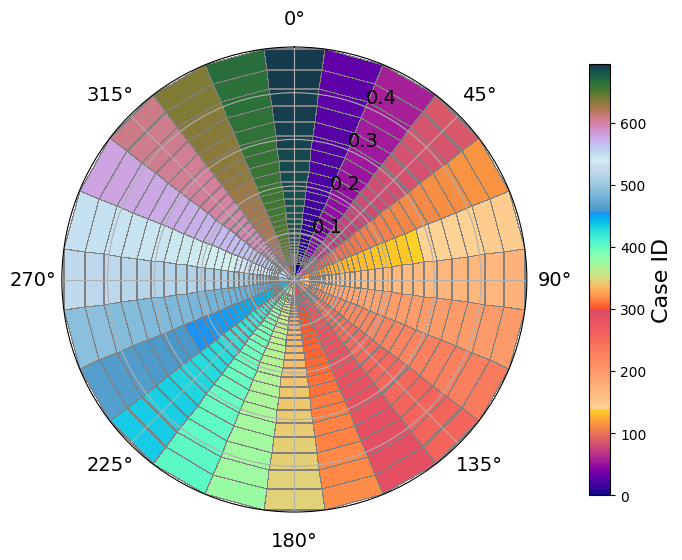

In [7]:
import numpy as np
from bluemath_tk.waves.binwaves import plot_selected_cases_grid

# Plot the cases grid
plot_selected_cases_grid(
    frequencies=np.array(np.unique(swan_cases_df["freq"])),
    directions=np.array(np.unique(swan_cases_df["dir"])),
    figsize=(8, 8),
)

In [8]:
import os
from bluemath_tk.wrappers.swan.swan_wrapper import BinWavesWrapper

# This section generates all necessary SWAN input files, organizing them into separate folders for each case.
# Define the input templates and output directory for the wrapper
templates_dir = os.path.join(os.getcwd(), "templates")
templates_name = ["INPUT"]
output_dir = os.path.join(os.getcwd(), "PANAMA")

swan_wrapper = BinWavesWrapper(
    templates_dir=templates_dir,
    templates_name=templates_name,
    metamodel_parameters=swan_cases_df.to_dict(orient="list"),
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=bathy.values,
    locations=locations.T,
)

2025-06-26 09:51:03,630 - BinWavesWrapper - WARNING - Parameter dir is not in the default_parameters
2025-06-26 09:51:03,631 - BinWavesWrapper - WARNING - Parameter freq is not in the default_parameters
2025-06-26 09:51:03,631 - BinWavesWrapper - WARNING - Parameter hs is not in the default_parameters
2025-06-26 09:51:03,632 - BinWavesWrapper - WARNING - Parameter tp is not in the default_parameters
2025-06-26 09:51:03,633 - BinWavesWrapper - WARNING - Parameter spr is not in the default_parameters
2025-06-26 09:51:03,633 - BinWavesWrapper - WARNING - Parameter gamma is not in the default_parameters


In [12]:
# Build the input files

swan_wrapper.build_cases(mode="one_by_one", cases_to_build=range(319, 329))
swan_cases_df.to_csv(os.path.join(output_dir, "swan_cases.csv"), index=False)

2025-06-26 09:53:19,710 - BinWavesWrapper - WARNING - cases_to_build was specified, so just range(319, 329) will be built.


## Execute SWAN

> ⏰ **Note:** To monitor the progress of your runs, you can execute the following cell anytime to check how many SWAN cases have completed (100% simulation finished).  
> It may take a while for the first cases to finish, so feel free to run the cell multiple times to stay updated.  
> Once all cases have reached 100%, you can proceed with the rest of the code.  
> You can also run the next cells even if only a few cases have completed, to check that everything is working as expected.



In [13]:
swan_wrapper.run_cases_in_background(launcher="serial", num_workers=1, cases_to_run=range(319, 329))

2025-06-26 09:53:36,795 - BinWavesWrapper - WARNING - Cases to run was specified, so just range(319, 329) will be run.


In [17]:
swan_wrapper.monitor_cases().loc[319:329]

,Case,Status
319,0319,100 %
320,0320,100 %
321,0321,100 %
322,0322,100 %
323,0323,100 %
324,0324,100 %
325,0325,100 %
326,0326,100 %
327,0327,100 %
328,0328,100 %


In [18]:
# Post-process the output files

cases_bulk_parameters = swan_wrapper.postprocess_cases(cases_to_postprocess=range(319, 329))
cases_bulk_parameters

2025-06-26 09:54:26,149 - BinWavesWrapper - WARNING - Cases to postprocess was specified, so just range(319, 329) will be postprocessed.
2025-06-26 09:54:26,150 - BinWavesWrapper - WARNING - Remember you can just use postprocess_case method to postprocess a single case.


<xarray.Dataset> Size: 1MB
Dimensions:   (case_num: 10, Yp: 97, Xp: 95)
Coordinates:
  * Xp        (Xp) float32 380B 5.527e+05 5.557e+05 ... 8.317e+05 8.347e+05
  * Yp        (Yp) float32 388B 7.186e+05 7.216e+05 ... 1.004e+06 1.007e+06
  * case_num  (case_num) int64 80B 319 320 321 322 323 324 325 326 327 328
Data variables:
    Hsig      (case_num, Yp, Xp) float32 369kB nan 0.94 0.94 ... nan nan nan
    Tm02      (case_num, Yp, Xp) float32 369kB nan 30.02 30.02 ... nan nan nan
    Dir       (case_num, Yp, Xp) float32 369kB nan 171.9 171.9 ... nan nan nan

/workspaces/BlueMath_tk/bluemath_tk/core/operations.py:349: RuntimeWarning: invalid value encountered in multiply
  x_rad = x_deg * np.pi / 180
/opt/conda/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


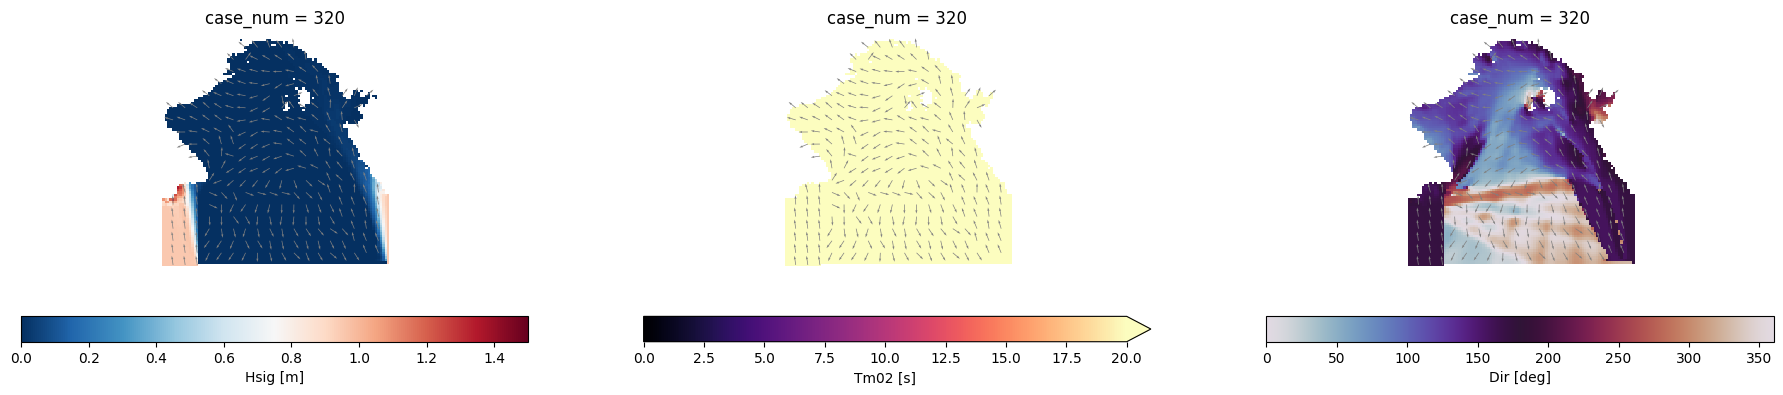

In [20]:
from utils.plotting import plot_case_variables

plot_case_variables(
    data=cases_bulk_parameters.isel(case_num=1),
    step=5,
)

## Plot ALL pre-run cases

"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argu

/opt/conda/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


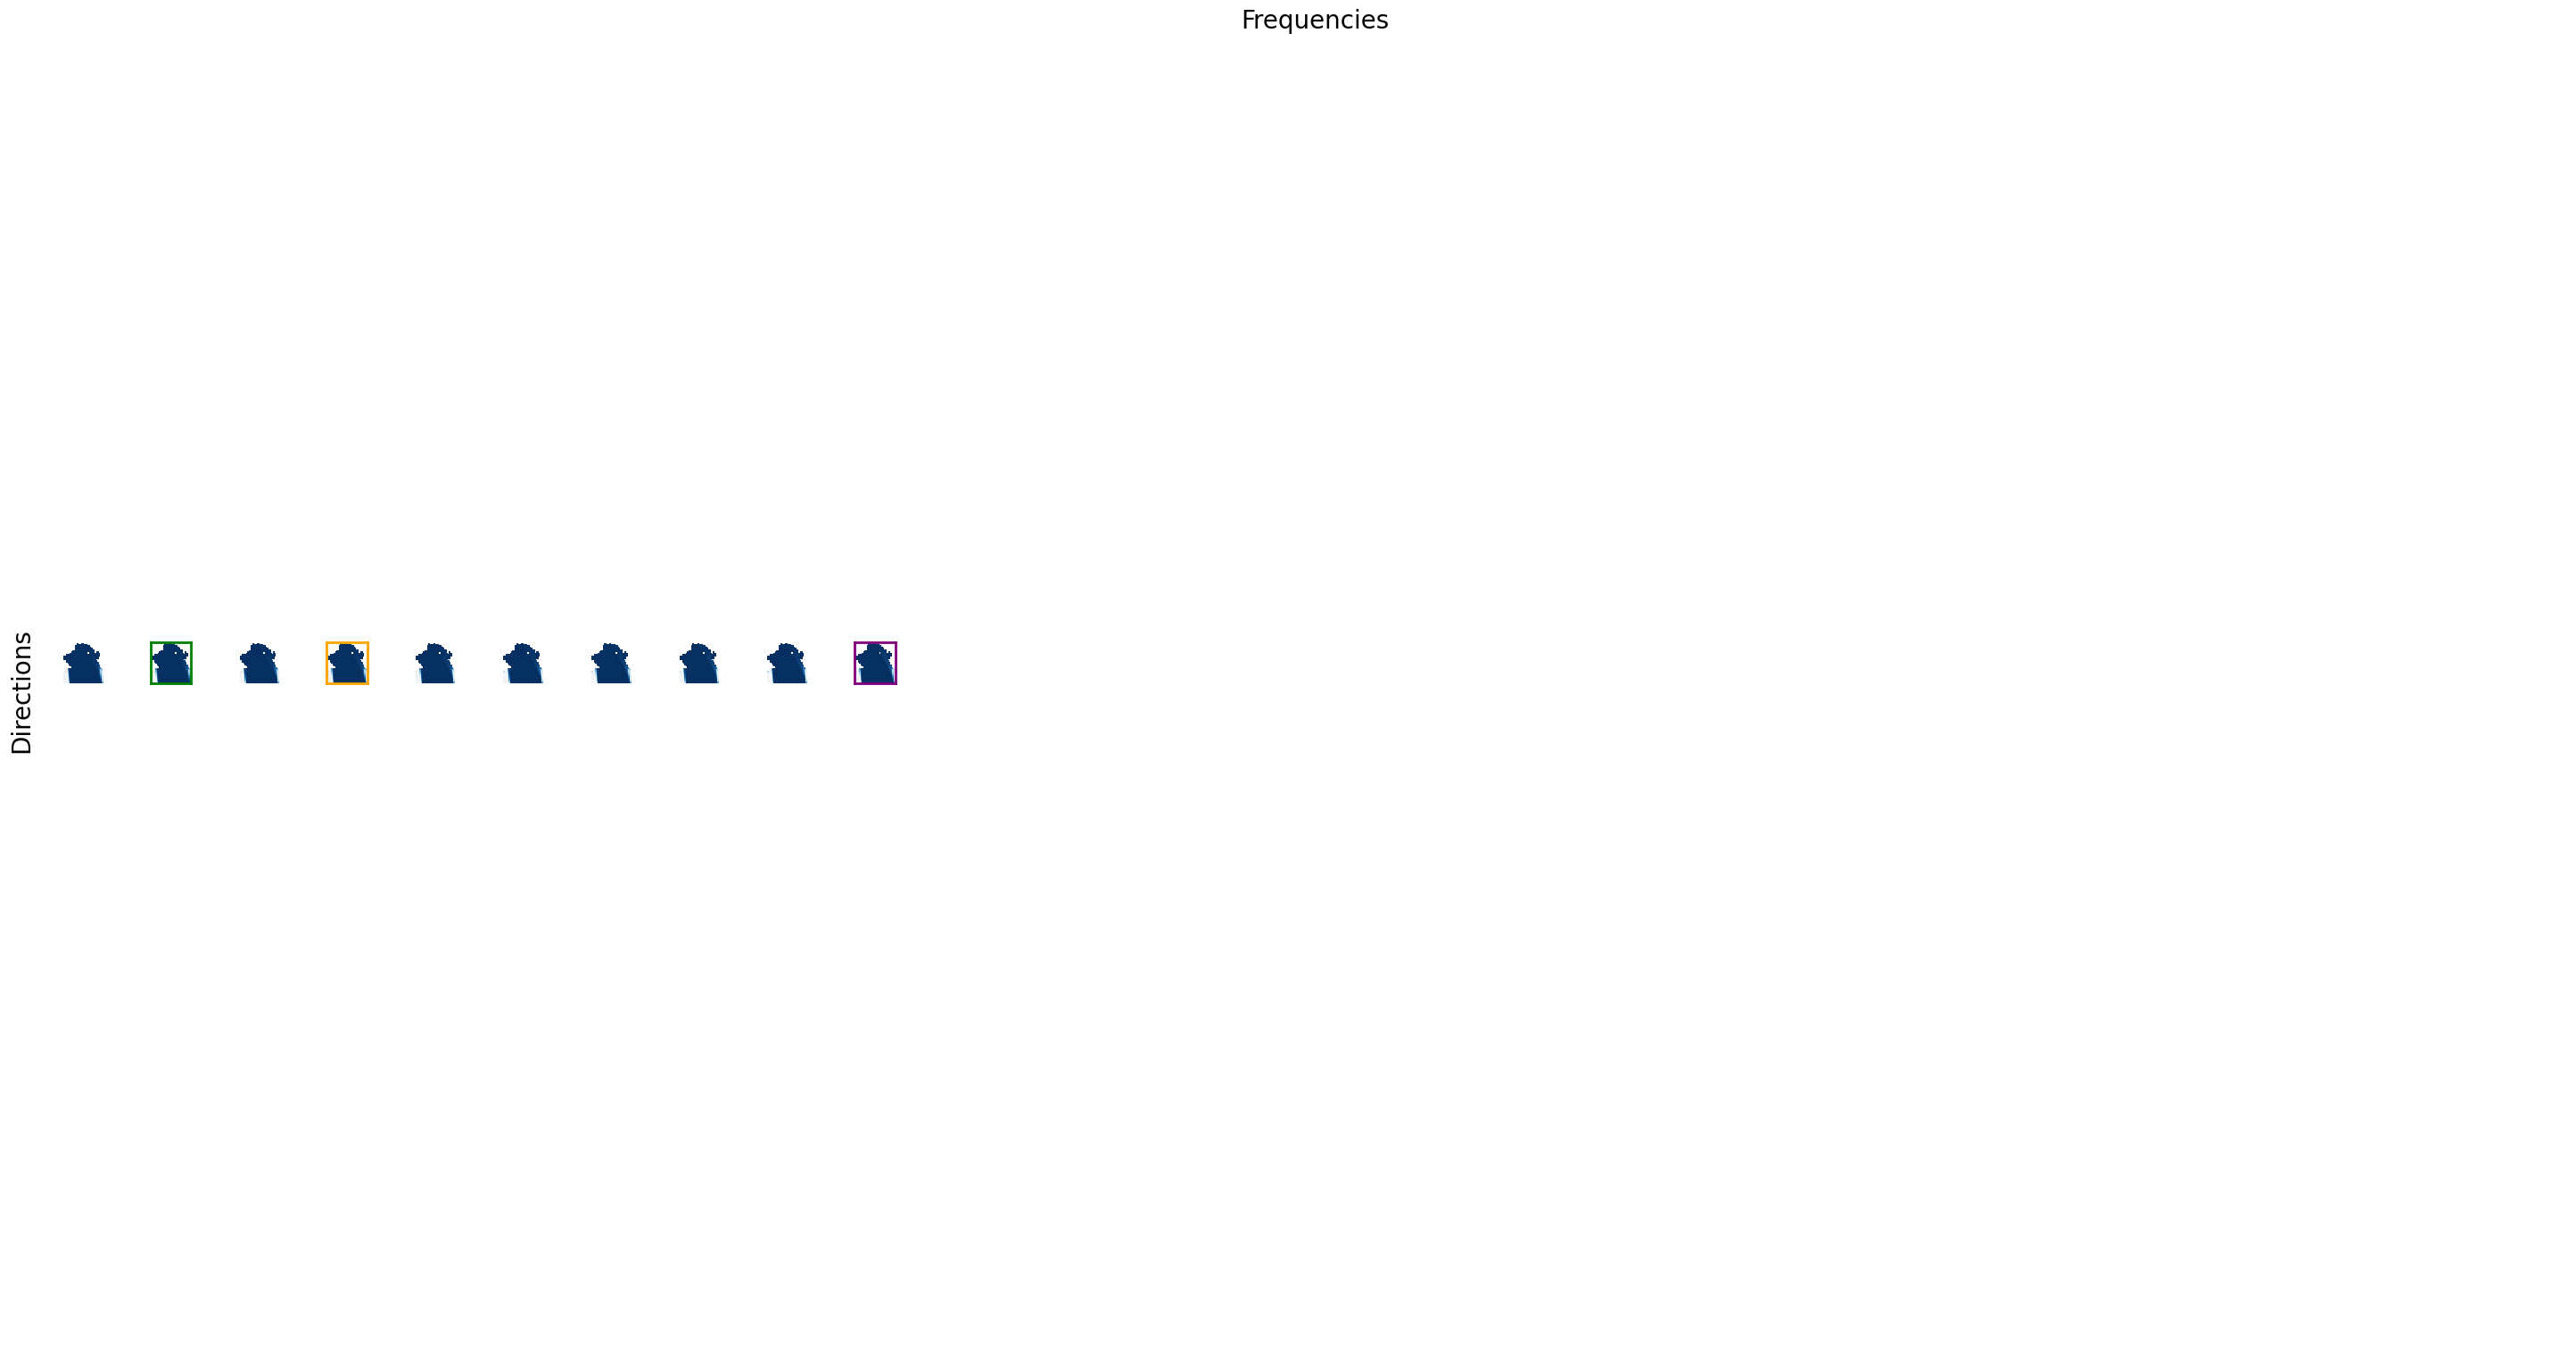

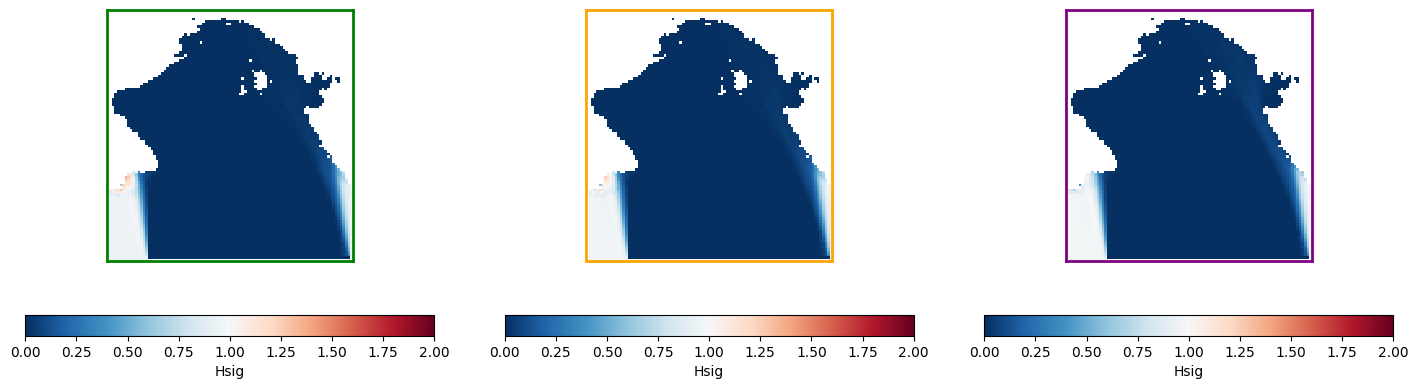

In [22]:
from utils.plotting import plot_cases_grid

plot_cases_grid(
    data=cases_bulk_parameters.Hsig.where(
        cases_bulk_parameters.case_num.isin(
            swan_cases_df.where(swan_cases_df["hs"] == 1.0).dropna().index.values
        ),
        cases_bulk_parameters.Hsig * 10,
    ),
    cases_to_plot=[320, 322, 328],
    num_directions=len(swan_cases_df["dir"].unique()),
    num_frequencies=len(swan_cases_df["freq"].unique()),
)

## Extract kp coefficients

In [23]:
from bluemath_tk.waves.binwaves import process_kp_coefficients

list_of_input_spectra = [
    os.path.join(case_dir, "input_spectra_N.bnd")
    for case_dir in swan_wrapper.cases_dirs
]
list_of_output_spectra = [
    os.path.join(case_dir, "output.spec") for case_dir in swan_wrapper.cases_dirs
]

kp_coefficients = process_kp_coefficients(
    list_of_input_spectra=list_of_input_spectra,
    list_of_output_spectra=list_of_output_spectra,
)
kp_coefficients

Error processing /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0000/input_spectra_N.bnd and /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0000/output.spec
[Errno 2] No such file or directory: '/workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0000/input_spectra_N.bnd'
Error processing /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0001/input_spectra_N.bnd and /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0001/output.spec
[Errno 2] No such file or directory: '/workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0001/input_spectra_N.bnd'
Error processing /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0002/input_spectra_N.bnd and /workspaces/BlueMath/climate_services/hindcast/BinWaves_Cantabria_MAGIC/PANAMA/0002/output.spec
[Errno 2] No such file or directory: '/workspaces/B

<xarray.DataArray 'efth' (case_num: 10, lat: 5, lon: 5, freq: 31, dir: 24)> Size: 1MB
array([[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]]],
      shape=(10, 5, 5, 31, 24))
Coordinates:
  * case_num  (case_num) int64 80B 319 320 321 322 323 324 325 326 327 328
  * lat       (lat) float64 40B 7.186e+05 7.906e+05 ... 9.346e+05 1.007e+06
  * lon       (lon) float64 40B 5.527e+05 6.232e+05 ... 7.642e+05 8.347e+05
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    time      datetime64[ns] 8B 2025-06-26T09:56:00

In [25]:
kp_coefficients.to_dataset(name="kps").drop(["time"]).assign_coords(
    utm_x=(("site"), swan_wrapper.locations[:, 0]),
    utm_y=(("site"), swan_wrapper.locations[:, 1]),
).to_netcdf("outputs/kp_coefficients.nc")

/tmp/ipykernel_3269/818261054.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  kp_coefficients.to_dataset(name="kps").drop(["time"]).assign_coords(
